# Nonlinear Devices in Pulsim

This notebook demonstrates the nonlinear device models available in Pulsim.

## Contents
1. IdealDiode
2. IdealSwitch
3. MOSFET Model
4. IGBT Model
5. Circuit Examples with Nonlinear Devices

In [1]:
from pathlib import Path
import sys

_root = Path.cwd()
_candidate_paths = []
for _ in range(6):
    for _rel in (('build-test', 'python'), ('build', 'python')):
        candidate = _root / _rel[0] / _rel[1]
        if candidate.is_dir():
            _candidate_paths.append(candidate)
    _root = _root.parent

_unique_candidates = []
_seen = set()
for candidate in _candidate_paths:
    cstr = str(candidate)
    if cstr in _seen:
        continue
    _seen.add(cstr)
    _unique_candidates.append(candidate)

_bootstrap_error = None
for candidate in _unique_candidates:
    cstr = str(candidate)
    if cstr not in sys.path:
        sys.path.insert(0, cstr)
    try:
        import pulsim  # noqa: F401
        break
    except Exception as exc:
        _bootstrap_error = exc
        if cstr in sys.path:
            sys.path.remove(cstr)
else:
    if _bootstrap_error is not None:
        raise _bootstrap_error

import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

## 1. IdealDiode

The `IdealDiode` models a diode with:
- High conductance (`g_on`) when forward biased
- Low conductance (`g_off`) when reverse biased

$$G = \begin{cases} g_{on} & V_{ak} > 0 \\ g_{off} & V_{ak} \leq 0 \end{cases}$$

In [2]:
# Create IdealDiode with default parameters
diode_default = ps.IdealDiode()
print("IdealDiode (default):")
print(f"  name: '{diode_default.name()}'")
print(f"  is_conducting: {diode_default.is_conducting()}")

# Create with custom parameters
diode_custom = ps.IdealDiode(g_on=1e4, g_off=1e-10, name="D1")
print(f"\nIdealDiode (custom):")
print(f"  Name: {diode_custom.name()}")

IdealDiode (default):
  name: ''
  is_conducting: False

IdealDiode (custom):
  Name: D1


## 2. IdealSwitch

The `IdealSwitch` is a voltage-controlled switch:
- `closed=True`: High conductance (short circuit)
- `closed=False`: Low conductance (open circuit)

In [3]:
# Create switches
sw_open = ps.IdealSwitch(closed=False, name="SW_open")
sw_closed = ps.IdealSwitch(closed=True, name="SW_closed")

print("IdealSwitch examples:")
print(f"  {sw_open.name()}: closed={sw_open.is_closed()}")
print(f"  {sw_closed.name()}: closed={sw_closed.is_closed()}")

# Switch can be controlled
sw_open.close()
print(f"\nAfter sw_open.close():")
print(f"  {sw_open.name()}: closed={sw_open.is_closed()}")

sw_open.open()
print(f"\nAfter sw_open.open():")
print(f"  {sw_open.name()}: closed={sw_open.is_closed()}")

IdealSwitch examples:
  SW_open: closed=False
  SW_closed: closed=True

After sw_open.close():
  SW_open: closed=True

After sw_open.open():
  SW_open: closed=False


## 3. MOSFET Model

The MOSFET model uses a simplified square-law model:

**Cutoff** ($V_{gs} < V_{th}$):
$$I_d = 0$$

**Linear/Triode** ($V_{gs} > V_{th}$, $V_{ds} < V_{gs} - V_{th}$):
$$I_d = K_p \left[ (V_{gs} - V_{th}) V_{ds} - \frac{V_{ds}^2}{2} \right] (1 + \lambda V_{ds})$$

**Saturation** ($V_{gs} > V_{th}$, $V_{ds} \geq V_{gs} - V_{th}$):
$$I_d = \frac{K_p}{2} (V_{gs} - V_{th})^2 (1 + \lambda V_{ds})$$

In [4]:
# Create MOSFETParams
mos_params = ps.MOSFETParams()
mos_params.vth = 2.0       # Threshold voltage (V)
mos_params.kp = 0.5        # Transconductance parameter (A/V²)
mos_params.lambda_ = 0.02  # Channel-length modulation (1/V)
mos_params.is_nmos = True  # NMOS (True) or PMOS (False)

print("MOSFETParams:")
print(f"  Vth:     {mos_params.vth} V")
print(f"  Kp:      {mos_params.kp} A/V²")
print(f"  Lambda:  {mos_params.lambda_} 1/V")
print(f"  Is NMOS: {mos_params.is_nmos}")

# Create MOSFET device
mosfet = ps.MOSFET(mos_params, "M1")
print(f"\nMOSFET device: {mosfet.name()}")

MOSFETParams:
  Vth:     2.0 V
  Kp:      0.5 A/V²
  Lambda:  0.02 1/V
  Is NMOS: True

MOSFET device: M1


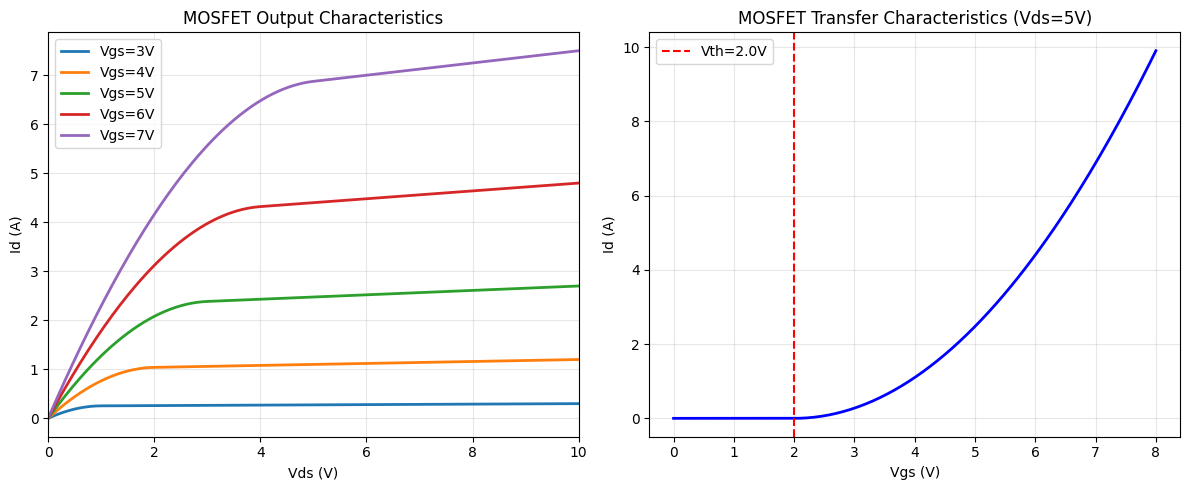

In [5]:
# Plot MOSFET I-V characteristics (conceptual)
Vth = mos_params.vth
Kp = mos_params.kp
lam = mos_params.lambda_

Vds = np.linspace(0, 10, 200)
Vgs_values = [3, 4, 5, 6, 7]  # Different gate voltages

plt.figure(figsize=(12, 5))

# Output characteristics (Id vs Vds)
plt.subplot(1, 2, 1)
for Vgs in Vgs_values:
    if Vgs <= Vth:
        Id = np.zeros_like(Vds)
    else:
        Vov = Vgs - Vth  # Overdrive voltage
        # Linear region: Vds < Vov
        # Saturation region: Vds >= Vov
        Id = np.where(
            Vds < Vov,
            Kp * ((Vgs - Vth) * Vds - 0.5 * Vds**2) * (1 + lam * Vds),
            0.5 * Kp * (Vgs - Vth)**2 * (1 + lam * Vds)
        )
    plt.plot(Vds, Id, linewidth=2, label=f'Vgs={Vgs}V')

plt.xlabel('Vds (V)')
plt.ylabel('Id (A)')
plt.title('MOSFET Output Characteristics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 10])

# Transfer characteristics (Id vs Vgs)
plt.subplot(1, 2, 2)
Vgs = np.linspace(0, 8, 200)
Vds_sat = 5  # Fixed Vds in saturation
Id = np.where(
    Vgs > Vth,
    0.5 * Kp * (Vgs - Vth)**2 * (1 + lam * Vds_sat),
    0
)
plt.plot(Vgs, Id, 'b-', linewidth=2)
plt.axvline(x=Vth, color='r', linestyle='--', label=f'Vth={Vth}V')
plt.xlabel('Vgs (V)')
plt.ylabel('Id (A)')
plt.title(f'MOSFET Transfer Characteristics (Vds={Vds_sat}V)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. IGBT Model

The IGBT (Insulated Gate Bipolar Transistor) model combines MOSFET gate control with bipolar transistor output characteristics:

- Threshold voltage $V_{th}$
- Collector-emitter saturation voltage $V_{ce(sat)}$
- On-state conductance $g_{on}$
- Off-state conductance $g_{off}$

In [6]:
# Create IGBTParams
igbt_params = ps.IGBTParams()
igbt_params.vth = 5.0       # Gate threshold voltage (V)
igbt_params.g_on = 100.0    # On-state conductance (S)
igbt_params.g_off = 1e-9    # Off-state conductance (S)
igbt_params.v_ce_sat = 2.0  # Collector-emitter saturation voltage (V)

print("IGBTParams:")
print(f"  Vth:      {igbt_params.vth} V")
print(f"  g_on:     {igbt_params.g_on} S")
print(f"  g_off:    {igbt_params.g_off} S")
print(f"  Vce_sat:  {igbt_params.v_ce_sat} V")

# Create IGBT device
igbt = ps.IGBT(igbt_params, "Q1")
print(f"\nIGBT device: {igbt.name()}")

IGBTParams:
  Vth:      5.0 V
  g_on:     100.0 S
  g_off:    1e-09 S
  Vce_sat:  2.0 V

IGBT device: Q1


## 5. Circuit Examples with Nonlinear Devices

### 5.1 Half-Wave Rectifier with IdealDiode

In [7]:
# Build half-wave rectifier circuit
def build_rectifier():
    ckt = ps.Circuit()
    gnd = ckt.ground()
    
    n_in = ckt.add_node("v_in")
    n_out = ckt.add_node("v_out")
    
    # AC source (simulated as DC for this example)
    ckt.add_voltage_source("Vin", n_in, gnd, 10.0)  # 10V
    
    # Diode
    ckt.add_diode("D1", n_in, n_out)
    
    # Load resistor
    ckt.add_resistor("R_load", n_out, gnd, 1000.0)
    
    return ckt

ckt_rect = build_rectifier()
print(f"Rectifier circuit: {ckt_rect.num_nodes()} nodes")

# DC analysis
dc_result = ps.dc_operating_point(ckt_rect)
print(f"\nDC Operating Point:")
print(f"  Success: {dc_result.success}")
if dc_result.success:
    sol = dc_result.newton_result.solution
    print(f"  V_in:  {sol[0]:.4f} V")
    print(f"  V_out: {sol[1]:.4f} V")
    print(f"  Diode drop: {sol[0] - sol[1]:.4f} V")

Rectifier circuit: 2 nodes

DC Operating Point:
  Success: True
  V_in:  10.0000 V
  V_out: 10.0000 V
  Diode drop: 0.0000 V


### 5.2 Switched Circuit with IdealSwitch

In [8]:
# Build switched RC circuit
def build_switched_rc(switch_closed=True):
    ckt = ps.Circuit()
    gnd = ckt.ground()
    
    n_in = ckt.add_node("v_in")
    n_sw = ckt.add_node("v_sw")
    n_out = ckt.add_node("v_out")
    
    ckt.add_voltage_source("Vin", n_in, gnd, 5.0)
    ckt.add_switch("SW1", n_in, n_sw, closed=switch_closed)
    ckt.add_resistor("R1", n_sw, n_out, 1000.0)
    ckt.add_capacitor("C1", n_out, gnd, 1e-6)
    
    return ckt

# Compare open vs closed switch
for closed in [True, False]:
    ckt = build_switched_rc(switch_closed=closed)
    dc = ps.dc_operating_point(ckt)
    
    state = "CLOSED" if closed else "OPEN"
    print(f"Switch {state}:")
    if dc.success:
        sol = dc.newton_result.solution
        print(f"  V_out = {sol[2]:.4f} V")
    else:
        print(f"  DC analysis failed")
    print()

Switch CLOSED:
  V_out = 5.0000 V

Switch OPEN:
  V_out = 2.5000 V



## Summary

Pulsim provides the following nonlinear device models:

| Device | Class | Key Parameters |
|--------|-------|----------------|
| Ideal Diode | `IdealDiode` | `g_on`, `g_off` |
| Ideal Switch | `IdealSwitch` | `g_on`, `g_off`, `closed` |
| MOSFET | `MOSFET` | `MOSFETParams`: `vth`, `kp`, `lambda_`, `is_nmos` |
| IGBT | `IGBT` | `IGBTParams`: `vth`, `g_on`, `g_off`, `v_ce_sat` |

### Key API

```python
# Diode
diode = ps.IdealDiode(g_on=1e3, g_off=1e-9, name="D1")
ckt.add_diode("D1", anode, cathode)

# Switch
sw = ps.IdealSwitch(closed=False, name="SW1")
sw.close()  # Turn on
sw.open()   # Turn off
ckt.add_switch("SW1", n1, n2, closed=True)

# MOSFET
params = ps.MOSFETParams()
params.vth = 2.0
mosfet = ps.MOSFET(params, "M1")

# IGBT
params = ps.IGBTParams()
params.vth = 5.0
igbt = ps.IGBT(params, "Q1")
```

**Next:** [RLC Circuits](06_rlc_circuits.ipynb)